In [1]:
import copy
import random
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from sklearn.metrics import confusion_matrix
from torch import nn, optim
from torch.utils.data import DataLoader, Subset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchvision import transforms
from sklearn.model_selection import train_test_split

c:\Users\tothm\.conda\envs\ai_learn\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] A megadott eljárás nem található'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class AddRandomNoise(object):
    def __init__(self, noise_range=(0, 0.3)):
        self.noise_range = noise_range

    def __call__(self, img):
        noise_level = random.uniform(self.noise_range[0], self.noise_range[1])
        noise = torch.randn_like(img) * noise_level
        return img + noise


training_transforms = transforms.Compose(
    [
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        AddRandomNoise(noise_range=(0, 0.2)),
    ]
)

torch.manual_seed(42)

test_dataset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())
train_dataset_augmented = torchvision.datasets.MNIST(root='data', train = True, transform = training_transforms, download = True)
train_dataset_clear = torchvision.datasets.MNIST(root='data', train = True, transform = transforms.ToTensor(), download = True)

# Splitting the correct datasets
all_indices = list(range(len(train_dataset_clear)))

all_indices_clear = list(range(len(train_dataset_clear)))

train_indices_clear, validation_indices_clear = train_test_split(all_indices_clear, test_size=0.1, random_state=42)

train_dataset = torch.utils.data.Subset(train_dataset_augmented, train_indices_clear)
validation_dataset = torch.utils.data.Subset(train_dataset_clear, validation_indices_clear)

print(len(train_dataset_augmented) ,len(train_dataset), len(validation_dataset))

60000 54000 6000


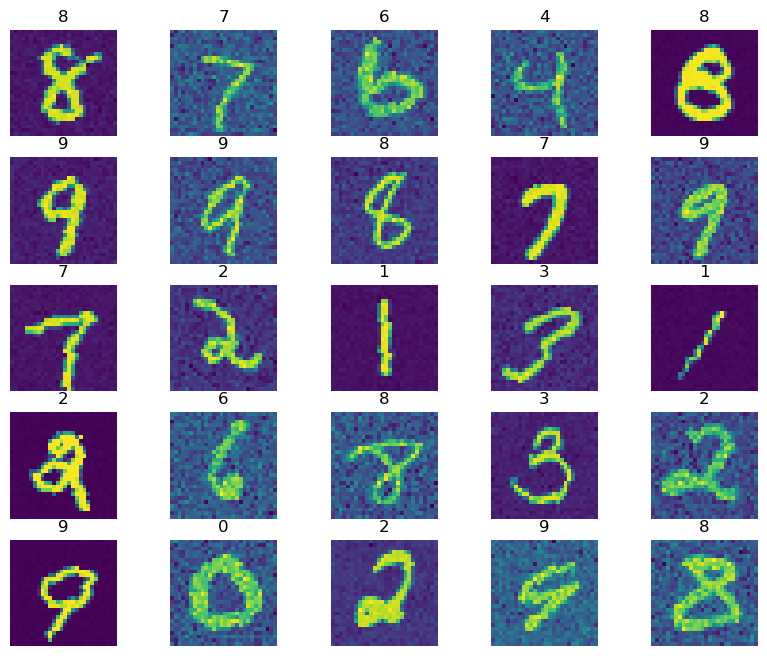

In [3]:
ds = train_dataset

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(ds), size=(1,)).item()
    img, label = ds[sample_idx] # type: ignore
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="viridis")

In [4]:
batch_size = 64

# Create data loaders for training, validation, and test sets
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


print(len(train_data_loader.dataset)) # type: ignore
print(len(valid_data_loader.dataset)) # type: ignore
print(len(test_data_loader.dataset)) # type: ignore

54000
6000
10000


In [5]:
# in: 28x28
def create_model():
    return nn.Sequential(
        nn.Conv2d(
            in_channels=1,
            out_channels=8,
            kernel_size=6,
            stride=1,
            padding=3,
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(
            in_channels=8,
            out_channels=32,
            kernel_size=2,
            stride=1,
            padding=0,
        ),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=3, stride=3),
        nn.Flatten(),
        nn.Linear(in_features=512, out_features=100),
        nn.ReLU(),
        nn.Linear(in_features=100, out_features=10),
    )

In [6]:
# example_model = create_model()
# x = torch.zeros(1, 1, 28, 28)

# for m in example_model:
#     x = m(x)
#     print(m, x.size())

In [7]:
def validate(model, data, device):
    total = 0
    correct = 0
    for images, labels in data:
        images = images.to(device)
        labels = labels.to(device)

        x = model(images)
        _, pred = torch.max(x, 1)
        pred = pred.cpu()  # Move predictions back to CPU if they were on GPU
        total += labels.size(0)
        correct += torch.sum(pred == labels.cpu())  # Move labels back to CPU for comparison

    return correct * 100. / total

In [12]:
def train(writer, numb_epoch=3, lr=0.01, device="cpu", log=True, patience = 5, factor = 0.65):
    accuracies = []
    best_model = cnn = create_model().to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=patience, factor=factor)
    max_accuracy = 0
    max_acc_epoch = 0
    no_max = 0
    max_count = 0
    for epoch in range(numb_epoch):
        for images, labels in train_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = loss_func(pred, labels)
            loss.backward()
            optimizer.step()

        accuracy_test = float(validate(cnn, valid_data_loader, device))
        accuracies.append(accuracy_test)
        scheduler.step(accuracy_test)
        if accuracy_test > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy_test
            max_acc_epoch = epoch
            if log:
                writer.add_scalar("New max/Epoch", no_max, max_count)
            no_max = 0
            max_count+=1
            print(f"-Saving Best Model with Accuracy: {accuracy_test}%, epoch: {max_acc_epoch}")
                
        else:
            no_max+=1
        print('Epoch:', epoch+1, "Test Accuracy :", accuracy_test, '%', "Learning rate: ", optimizer.param_groups[0]["lr"] )
        if log:
            writer.add_scalar("Accuracy/Epoch", accuracy_test, epoch)
            writer.add_scalar("Learning rate/Epoch", optimizer.param_groups[0]["lr"], epoch)
    plt.plot(accuracies)
    plt.plot(max_acc_epoch, max_accuracy, 'o')
    
    if log:
        writer.add_scalar("New max/Epoch", no_max, max_count)
        
    return best_model, max_accuracy

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")

No Cuda Available


In [ ]:
# run_name = "12 - Long test lr 0 02 patience 14 factor 075"
# writer = SummaryWriter(f'./runs/{run_name}')
# model, max_accuracy = train(384, device=device, log=True, patience=14, factor=0.75, lr=0.02) # type: ignore
# writer.close()

-Saving Best Model with Accuracy: 97.03333282470703%, epoch: 0
Epoch: 1 Test Accuracy : 97.03333282470703 % Learning rate:  0.02
-Saving Best Model with Accuracy: 97.38333129882812%, epoch: 1
Epoch: 2 Test Accuracy : 97.38333129882812 % Learning rate:  0.02
-Saving Best Model with Accuracy: 97.61666870117188%, epoch: 2
Epoch: 3 Test Accuracy : 97.61666870117188 % Learning rate:  0.02
Epoch: 4 Test Accuracy : 97.43333435058594 % Learning rate:  0.02
-Saving Best Model with Accuracy: 97.83333587646484%, epoch: 4
Epoch: 5 Test Accuracy : 97.83333587646484 % Learning rate:  0.02
Epoch: 6 Test Accuracy : 97.51667022705078 % Learning rate:  0.02
Epoch: 7 Test Accuracy : 97.73332977294922 % Learning rate:  0.02
Epoch: 8 Test Accuracy : 97.5999984741211 % Learning rate:  0.015
Epoch: 9 Test Accuracy : 97.5 % Learning rate:  0.015
-Saving Best Model with Accuracy: 98.19999694824219%, epoch: 9
Epoch: 10 Test Accuracy : 98.19999694824219 % Learning rate:  0.015
-Saving Best Model with Accuracy: 9

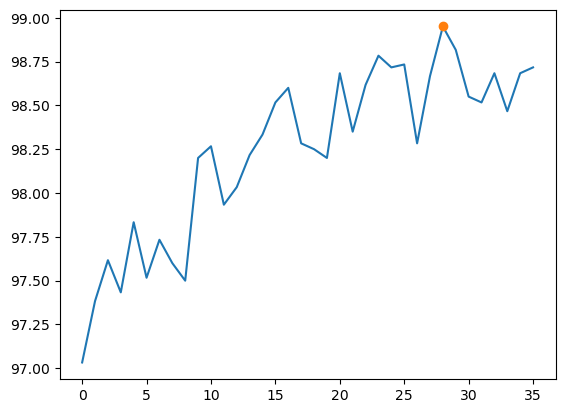

In [15]:
run_name = "13 - Short test lr 0 02 patience 2 factor 075"
writer = SummaryWriter(f'./runs/{run_name}')
model, max_accuracy = train(writer, numb_epoch=36, device=device, log=True, patience=2, factor=0.75, lr=0.02) # type: ignore

writer.flush()
writer.close()

In [16]:
ts = datetime.now().strftime('%Y%m%d%H%M%S')

torch.save(model.state_dict(), f'model_{ts}_{max_accuracy:0.3f}.pth')

In [17]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in data:
            images = images.to(device)
            labels = labels.to(device)

            x = model(images)
            _, pred = torch.max(x, 1)
            pred = pred.data.cpu()
            
            correct_predictions += torch.sum(pred == labels.data.cpu()).item()
            total_samples += labels.size(0)

            y_pred.extend(list(pred.numpy()))
            y_true.extend(list(labels.numpy()))

    accuracy = (correct_predictions / total_samples) * 100.0

    return np.array(y_pred), np.array(y_true), accuracy

In [18]:
y_pred, y_true, test_accuracy = predict_dl(model, test_data_loader)
print("Accuracy: ", test_accuracy, "%")
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

Accuracy:  98.91 %


,0,1,2,3,4,5,6,7,8,9
0,979,0,0,0,0,0,0,1,0,0
1,0,1134,0,0,0,0,0,1,0,0
2,1,6,1020,0,0,0,0,3,2,0
3,0,2,1,997,0,3,0,3,4,0
4,0,0,1,0,971,0,3,0,0,7
5,2,0,0,3,0,874,2,1,2,8
6,4,0,0,0,1,3,947,0,2,1
7,0,1,8,0,0,0,0,1014,2,3
8,1,0,1,2,2,2,0,1,963,2
9,0,0,0,0,7,2,0,5,3,992


In [ ]:
# summary(model, (1, 28, 28))